# CNN

Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.layers import Dense, Dropout

# Load dataset

In [2]:
data_dir = r"C:\Users\apx180\Documents\CIClocal\tesis\air_pollution_data\traffic_images\MER"
data_dir = r"C:\Users\valer\Documents\CIC\doctorado\air_pollution\traffic_flow\vector\traffic_images\MER"

In [3]:
BATCH_SIZE = 24
IMG_SIZE = (150, 150)

train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            validation_split=0.2,
                                                            subset="training",
                                                            seed=42,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            validation_split=0.2,
                                                            subset="validation",
                                                            seed=42,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

class_names = train_dataset.class_names



Found 7125 files belonging to 3 classes.
Using 5700 files for training.
Found 7125 files belonging to 3 classes.
Using 1425 files for validation.


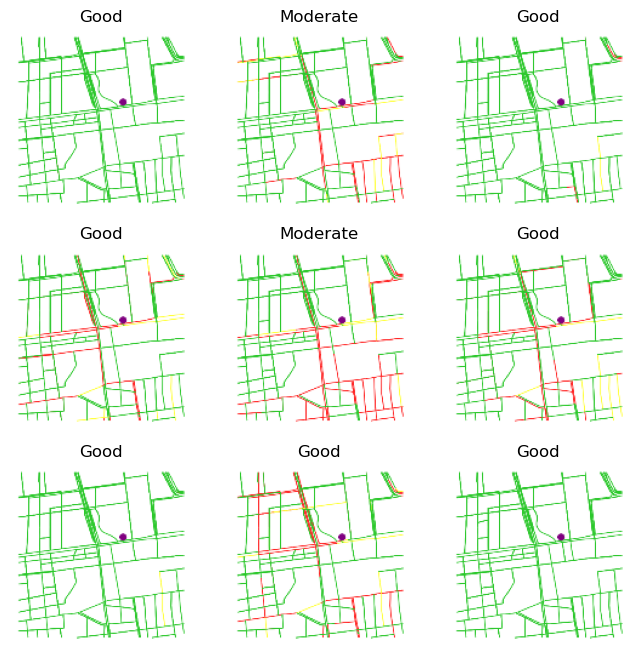

In [4]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Estructura de la CNN
Aquí se crea la estructura de la parte de **convolución** de la red, se definen las capas que utilizará. Comúnmente se van colocando de forma secuencial capas Conv2D y MaxPooling2D.


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [6]:
num_classes = 3

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),
  tf.keras.layers.Conv2D(64,3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  Dropout(0.2),
  tf.keras.layers.Conv2D(128,3, activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  Dropout(0.2),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [7]:
import torch
import torch.nn as nn

In [8]:
class CNNJetTagger(nn.Module):
    def __init__(self):
        super(CNNJetTagger, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1))
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (num_bins // 4) * (num_bins // 4), 128)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [9]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model2.h5',  # Ruta donde se guarda el modelo
    monitor='val_accuracy',    # Métrica a monitorear
    save_best_only=True,       # Solo guarda si la métrica mejora
    mode='max',                # 'max' porque queremos maximizar la accuracy
    verbose=1                  # Muestra mensajes sobre el guardado
)

### Juntando y entrenando el modelo

In [10]:
import tensorflow as tf
"""
def f1_score(y_true, y_pred):
    # Convertir predicciones a etiquetas binarias (si es necesario)
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int32)

    # Calcular métricas
    precision = tf.metrics.Precision()(y_true, y_pred)
    recall = tf.metrics.Recall()(y_true, y_pred)

    # Calcular F1-score
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1
"""
import tensorflow as tf

# Define global precision and recall metrics
precision_metric = tf.keras.metrics.Precision()
recall_metric = tf.keras.metrics.Recall()

def f1_score(y_true, y_pred):
    # Convert predictions to labels
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.cast(y_true, tf.int32)

    # Update precision and recall
    precision_metric.update_state(y_true, y_pred)
    recall_metric.update_state(y_true, y_pred)

    # Compute precision and recall values
    precision = precision_metric.result()
    recall = recall_metric.result()

    # F1 score
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

# Train the model
epochs = 25
model.compile(optimizer='sgd',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy', f1_score])
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs,
    callbacks=[checkpoint_callback] )


Epoch 1/25


c:\Users\valer\anaconda3\Lib\site-packages\keras\src\backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


238/238 [==============================] - ETA: 0s - loss: 0.8426 - accuracy: 0.6616 - f1_score: 0.0395
Epoch 1: val_accuracy improved from -inf to 0.64842, saving model to best_model2.h5
238/238 [==============================] - 102s 425ms/step - loss: 0.8426 - accuracy: 0.6616 - f1_score: 0.0395 - val_loss: 0.8641 - val_accuracy: 0.6484 - val_f1_score: 0.0083
Epoch 2/25


c:\Users\valer\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


238/238 [==============================] - ETA: 0s - loss: 0.7446 - accuracy: 0.6765 - f1_score: 0.0150
Epoch 2: val_accuracy improved from 0.64842 to 0.65404, saving model to best_model2.h5
238/238 [==============================] - 108s 452ms/step - loss: 0.7446 - accuracy: 0.6765 - f1_score: 0.0150 - val_loss: 0.6532 - val_accuracy: 0.6540 - val_f1_score: 0.0744
Epoch 3/25
238/238 [==============================] - ETA: 0s - loss: 0.5998 - accuracy: 0.7360 - f1_score: 0.2131
Epoch 3: val_accuracy improved from 0.65404 to 0.74105, saving model to best_model2.h5
238/238 [==============================] - 105s 440ms/step - loss: 0.5998 - accuracy: 0.7360 - f1_score: 0.2131 - val_loss: 0.5837 - val_accuracy: 0.7411 - val_f1_score: 0.3465
Epoch 4/25
238/238 [==============================] - ETA: 0s - loss: 0.5594 - accuracy: 0.7642 - f1_score: 0.4144
Epoch 4: val_accuracy improved from 0.74105 to 0.77123, saving model to best_model2.h5
238/238 [==============================] - 104s 436

### Evaluar el modelo

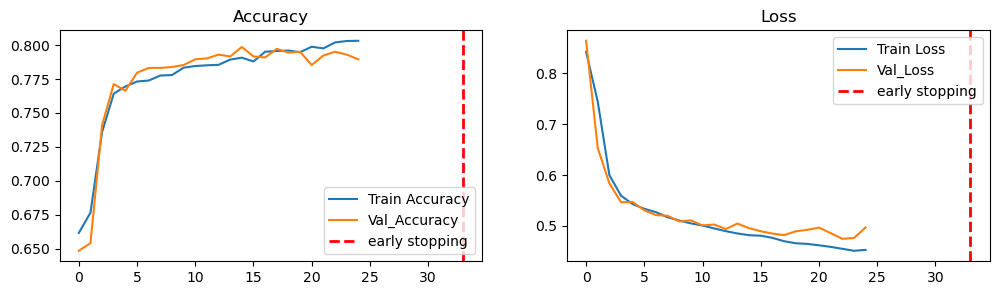

In [11]:
from matplotlib import pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val_Accuracy')
plt.axvline(x=33, color='red', linestyle='--', linewidth=2, label='early stopping')
plt.legend(loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val_Loss')
plt.title('Loss')
plt.axvline(x=33, color='red', linestyle='--', linewidth=2, label='early stopping')
plt.legend(loc='upper right')

plt.show()

In [12]:
predictions = model.predict(validation_dataset)

60/60 [==============================] - 5s 82ms/step


In [13]:
predictions

array([[8.0770910e-01, 1.8530056e-01, 6.9903992e-03],
       [1.9596671e-01, 5.5996221e-01, 2.4407107e-01],
       [9.9687153e-01, 3.0914641e-03, 3.7131616e-05],
       ...,
       [9.8053437e-01, 1.9071272e-02, 3.9436700e-04],
       [9.9681538e-01, 3.1428933e-03, 4.1664789e-05],
       [9.2607075e-01, 6.8832546e-02, 5.0967708e-03]], dtype=float32)

In [14]:
# Obtener las clases predichas
predicted_classes = np.argmax(predictions, axis=1)

# Convertir índices de clase a nombres de clase
predicted_class_names = [class_names[i] for i in predicted_classes]
true_class_names = [class_names[i] for i in labels.numpy()]

In [15]:
predicted_classes

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [16]:
predicted_class_names

['Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Moderate',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Moderate',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Moderate',
 'Moderate',
 'Good',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',
 'Moderate',
 'Good',
 'Moderate',
 'Moderate',
 'Good',
 'Good',
 'Good',
 'Good',
 'Good',


In [17]:

# Obtener las etiquetas verdaderas
true_labels = np.concatenate([y.numpy() for _, y in validation_dataset], axis=0)
true_class_names = [class_names[i] for i in true_labels]
print(true_labels)
print(true_class_names)

[0 2 0 ... 0 0 0]
['Good', 'Unhealthy', 'Good', 'Good', 'Good', 'Moderate', 'Good', 'Good', 'Moderate', 'Good', 'Good', 'Moderate', 'Moderate', 'Good', 'Good', 'Good', 'Unhealthy', 'Moderate', 'Good', 'Unhealthy', 'Good', 'Good', 'Good', 'Good', 'Moderate', 'Good', 'Moderate', 'Good', 'Good', 'Moderate', 'Moderate', 'Good', 'Good', 'Moderate', 'Good', 'Good', 'Good', 'Good', 'Moderate', 'Moderate', 'Good', 'Good', 'Good', 'Good', 'Good', 'Unhealthy', 'Good', 'Moderate', 'Good', 'Moderate', 'Good', 'Moderate', 'Moderate', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Moderate', 'Unhealthy', 'Moderate', 'Moderate', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Moderate', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Moderate', 'Unhealthy', 'Good', 'Good', 'Good', 'Good', 'Good', 'Good', 'Unhealthy', 'Good', 'Moderate', 'Good', 'Good', 'Good', 'Moderate', 'Good', 'Good', 'Good', 'Moderate', 'Good', 'Good', 'G

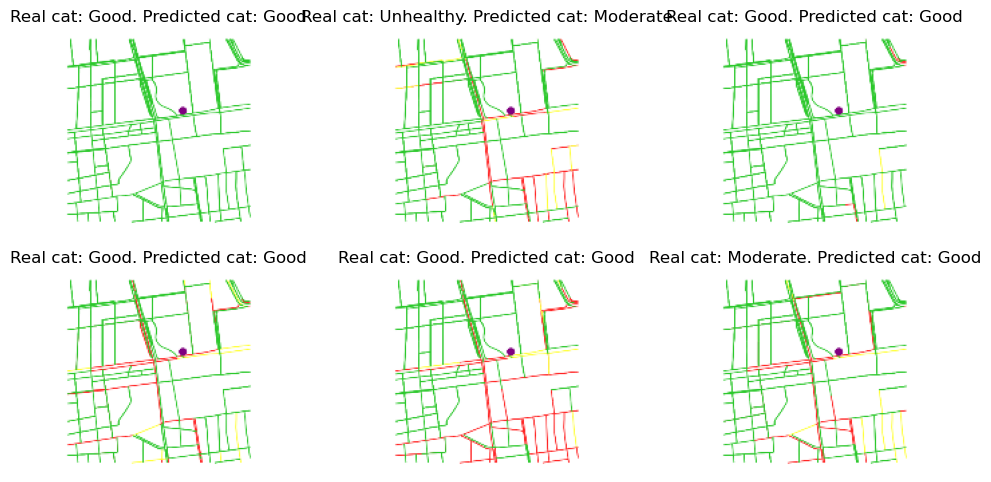

In [18]:
# Mostrar algunas imágenes junto con sus predicciones y etiquetas reales
plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(f'Real cat: {true_class_names[i]}. Predicted cat: {predicted_class_names[i]}')
    plt.axis('off')

plt.show()

In [19]:
from sklearn.metrics import accuracy_score

# Calcular la precisión
accuracy = accuracy_score(true_labels, predicted_classes)
print(f'Precisión en el conjunto de validación: {accuracy:.4f}')


Precisión en el conjunto de validación: 0.7895


In [20]:
import numpy as np

# Obtener las etiquetas verdaderas y las predicciones
y_true = np.concatenate([y.numpy() for _, y in validation_dataset], axis=0)
y_pred = np.argmax(model.predict(validation_dataset), axis=1)


60/60 [==============================] - 5s 82ms/step


In [21]:
y_true

array([0, 2, 0, ..., 0, 0, 0])

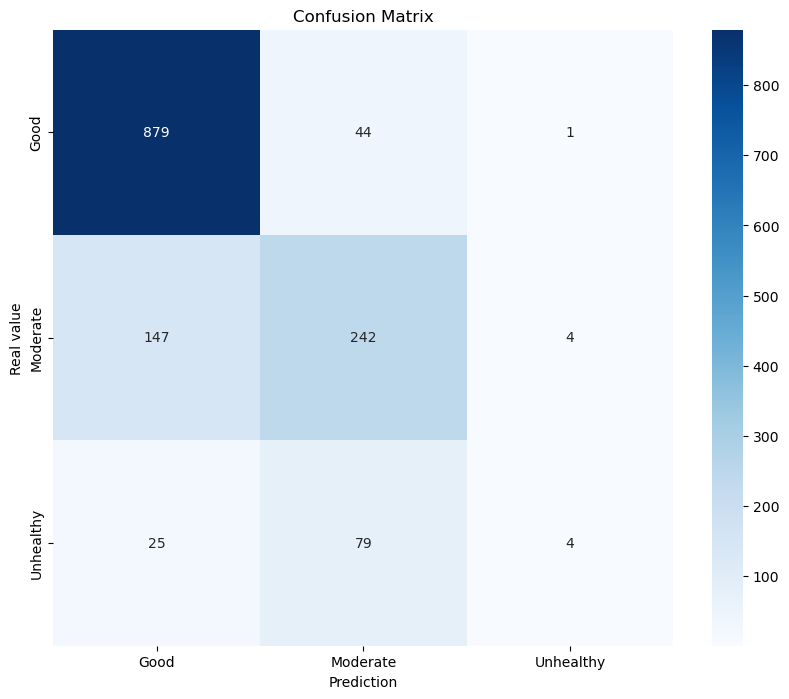

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Visualizar la matriz de confusión
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediction')
plt.ylabel('Real value')
plt.title('Confusion Matrix')
plt.show()


# Sequential CRNN

### Clasification

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(altura, ancho, canales)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Para clasificación binaria; usa softmax para multicategoría
])


NameError: name 'altura' is not defined

### Regression

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(altura, ancho, canales)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1)  # Para regresión, salida sin activación
])


# Multi input

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers

# Entrada para las imágenes
image_input = Input(shape=(altura, ancho, canales), name="image_input")
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

# Entrada para los datos adicionales (sensor, fecha, hora)
sensor_input = Input(shape=(n_features_sensores,), name="sensor_input")
y = Dense(64, activation='relu')(sensor_input)

# Combina las salidas de las dos ramas (imagen y datos tabulares)
combined = Concatenate()([x, y])

# Capa de salida (para regresión o clasificación)
output = Dense(1, activation='linear')(combined)  # Para regresión (cambiar a 'softmax' para clasificación)

# Crear el modelo
model = Model(inputs=[image_input, sensor_input], outputs=output)

# Compilación del modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [1]:
import pandas as pd